# Problem



Our problem to solve was a modified version of the Travel Salesman Problem: additionally, we have cost associated with each node, and we had to select exactly 50% of the total nodes.

# Code

In [1]:
import pandas as pd
import random 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
tsp_a = pd.read_csv("TSPA.csv", sep=';',header=None)
tsp_b = pd.read_csv("TSPB.csv", sep=';',header=None)

tsp_a 

,0,1,2
0,1510,353,84
1,3042,123,483
2,2145,389,1462
3,1030,365,1986
4,2125,360,145
...,...,...,...
195,1023,1258,197
196,3192,1271,1183
197,3735,1879,1461
198,3983,299,1309


## Random solution

In [4]:
data = tsp_a
selected_data = data.sample(data.shape[0] // 2)
selected_data    

,0,1,2
118,919,589,1349
132,949,792,354
25,524,935,1179
156,2689,1975,978
167,2548,936,232
...,...,...,...
38,1525,389,1945
157,1777,1357,1159
122,3265,1986,1969
136,1255,942,1600


In [5]:
def get_total_random_cost(data: pd.DataFrame) -> int:
    cost = data[2].sum()
    point = data.iloc[0][:2]
    for idx,row in data[1:].iterrows():
        cost += int(np.linalg.norm(point-row[:2]))
        point = row[:2]
    cost += int(np.linalg.norm(point-data.iloc[0][:2]))
    return cost


In [6]:
get_total_random_cost(selected_data)

244077

In [7]:
for n in range(3):
    selected_data = data.sample(data.shape[0] // 2)
    print(f"Total cost: {get_total_random_cost(selected_data)}")


Total cost: 263942
Total cost: 257639
Total cost: 269762


In [42]:
def generate_dm(df, show=True):
    temp = df[[0, 1]].to_numpy()
    dm = distance_matrix(temp, temp)


    temp = df[2].to_numpy() // 2
    temp = temp * np.ones((200, 200))
    dm = dm+temp+temp.T
    dm = dm // 1

    for i in range(200):
        dm[i][i] = np.inf

    
    if show: 
        df_dist = pd.DataFrame(dm)
        display(df_dist)
    return dm


## Nearest neighbor

0. Calculate distance matrix
1. Add initial node to cycle
2. While length of current cycle is less then 100:

    2.1 Calculate difference between not yet visited node and last node
    
    2.2 Find NN
    
    2.3 Add this NN to cycle
    
    2.4 Add distance between last node and NN, and add also cost of this node to total cost
    
    2.5 Remove NN from not yet visited
    
3. Add to total cost distance between first and last node in cycle 

In [55]:
def nearest_neighbour(data, start_node_idx, dm):
    distance_matrix = dm.copy()
    cycle = [start_node_idx]
    cost = 0
    distance_matrix[:,cycle[-1]] = np.inf
    while len(cycle) != 100:
        cost += distance_matrix[cycle[-1]].min()
        cycle.append(distance_matrix[cycle[-1]].argmin())
        distance_matrix[:,cycle[-1]] = np.inf

    cost += dm[cycle[-1]][cycle[0]]
    return cost, cycle
dm = generate_dm(tsp_a, False)
cost, cycle = nearest_neighbour(tsp_a, 0, dm)
cost

88718.0

## Greedy cycle

0. Calculate distance matrix between each pair of nodes, add to each distance avg cost of both nodes.
1. For the initial node find NN, and add edges between them(in both directions) to the output cycle.
2. While output cycle length is less then 100:

    2.1 For each edge(E_1, E_2) in output cycle: 
        2.1.1 For each node(N) not yet in output cycle:
            2.1.1.1 Calculate change in distance(edge(E_1, N) + edge(N, E_2) - edge(E_1, E_2))
    2.2 Select this new node, for which above change is minimal
    2.3 Remove "useless" edge from cycle, and add 2 newones
    2.4 Remove newly find node from not yet in output cycle 

    

In [45]:
def get_total_greedy_cycle_cost(data: pd.DataFrame, dm: np.array, start_node_idx: int = None,) -> int:
    data_indexes = data.index.to_list()
    cost = 0
    
    if start_node_idx is None:
        start_node_idx = random.choice(data_indexes)
        
    node = data_indexes[start_node_idx]
    next_node = dm[node].argmin()

    data_indexes.remove(node)
    data_indexes.remove(next_node)
    
    edge1 = str(node) + '_' + str(next_node)
    edge2 = str(next_node) + '_' + str(node)
    cycle = [(edge1, dm[node].min()), (edge2, dm[node].min())]
    
    while len(cycle) < 100:

        min_dist = 100000
        new_edge1 = None 
        new_edge2 = None
        bad_edge = None
        new_node = None
        
        for edge, dist in cycle:
            old_node1, old_node2 = [int(i) for i in edge.split('_')]
            for node in data_indexes:
                edge1 = str(old_node1) + '_' + str(node)
                edge2 = str(node) + '_' + str(old_node2)
                change = dm[old_node1][node] + dm[old_node2][node] - dist
                
                if change < min_dist:
                    min_dist = change
                    new_edge1 = (edge1, dm[old_node1][node])
                    new_edge2 = (edge2, dm[old_node2][node])
                    bad_edge = (edge, dist)
                    new_node = node
                    
        cycle.remove(bad_edge)
        cycle.append(new_edge1)
        cycle.append(new_edge2)
        data_indexes.remove(new_node)

    cost = sum([x[1] for x in cycle])

    return cost, cycle
dm = generate_dm(tsp_a, False)    
cost, cycle = get_total_greedy_cycle_cost(tsp_a, dm, 0)    
cost

76598.0

# Experyments

## Instnace A

### Random

In [75]:
totals = []
history = []
data = tsp_a
for n in tqdm(range(200)):
    selected_data = data.sample(data.shape[0] // 2)
    history.append(selected_data)
    totals.append(get_total_random_cost(selected_data))
totals = np.array(totals)
print("Best score: ", totals.min())
print("Worst score: ", totals.max())
print("Mean score: ", totals.mean())

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 43.06it/s]

Best score:  235949
Worst score:  295350
Mean score:  263491.155


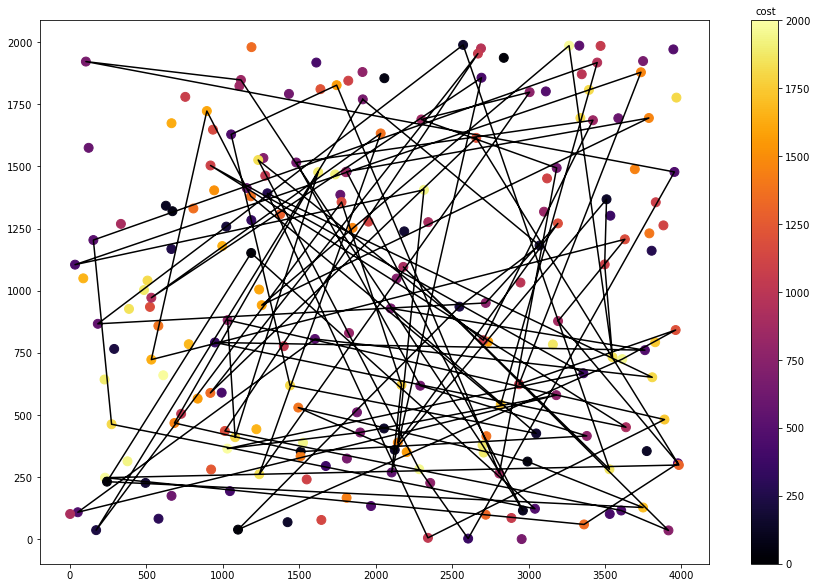

In [89]:
best_sol = history[totals.argmin()]

order = selected_data.index.to_list()
cycle = tsp_a.loc[order]
cycle = cycle.append(cycle.iloc[0])

plt.figure(figsize=(15, 10))
plt.scatter(tsp_a[0], tsp_a[1], 80, tsp_a[2], cmap='inferno')
plt.clim(0, 2000)
plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
plt.plot(cycle[0], cycle[1], c='black')
plt.show()

### Nearest neighbor

In [92]:
totals = []
dm = generate_dm(tsp_a, False)
for n in tqdm(range(200)):
    totals.append(nearest_neighbour(tsp_a, n, dm)[0]) 
totals = np.array(totals)
print("Best score: ", totals.min())
print("Worst score: ", totals.max())
print("Mean score: ", totals.mean())

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2126.95it/s]

Best score:  84149.0
Worst score:  97583.0
Mean score:  89420.22


37


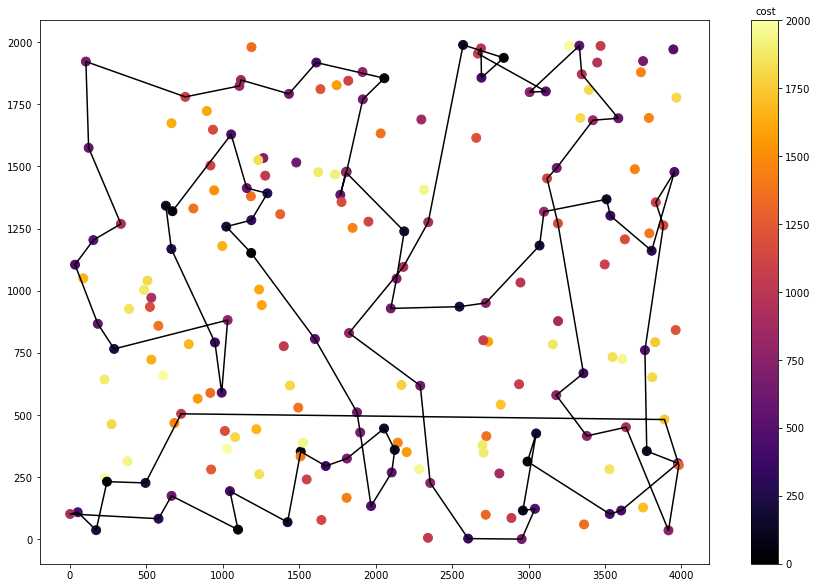

In [93]:
best_sol = totals.argmin()
print(best_sol)
cost, history = nearest_neighbour(tsp_a,best_sol, dm)

cycle = tsp_a.loc[history]
cycle = cycle.append(cycle.iloc[0])

plt.figure(figsize=(15, 10))
plt.scatter(tsp_a[0], tsp_a[1], 80, tsp_a[2], cmap='inferno')
plt.clim(0, 2000)
plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
plt.plot(cycle[0], cycle[1], c='black')
plt.show()

### Greedy cycle

In [94]:
totals = []
for i in tqdm(range(200)):
    totals.append(get_total_greedy_cycle_cost(tsp_a, dm, i)[0])
totals = np.array(totals)
print("Best score: ", totals.min())
print("Worst score: ", totals.max())
print("Mean score: ", totals.mean())

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:19<00:00,  1.00it/s]

Best score:  75566.0
Worst score:  79799.0
Mean score:  76961.72


150


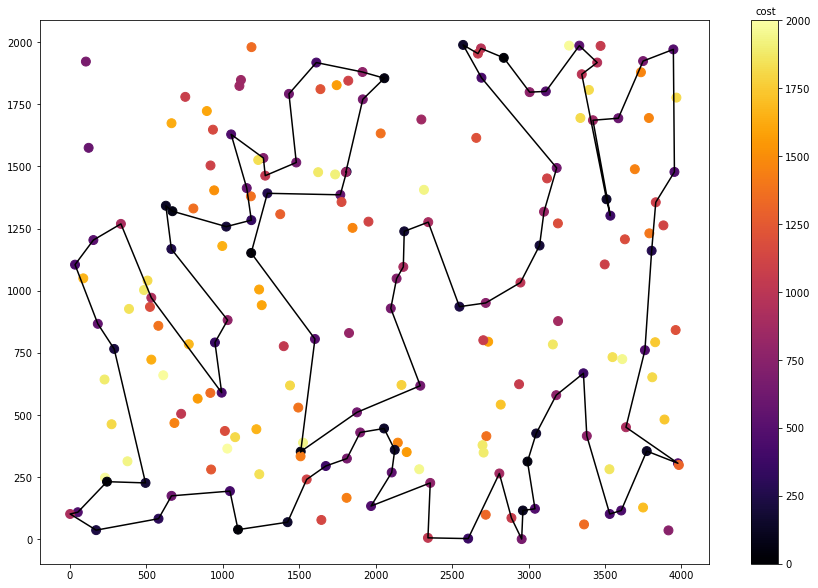

In [95]:
best_sol = totals.argmin()
print(best_sol)
cycle = get_total_greedy_cycle_cost(tsp_a, dm, best_sol)[1]
cycle = [x[0].split('_') for x in cycle ]
order = ['0']
while len(order) < 100:
    for n1, n2 in cycle:
        if n1 == order[-1]:
            order.append(n2)

order = [int(x) for x in order]
cycle = tsp_a.loc[order]
cycle = cycle.append(cycle.iloc[0])
# cycle

plt.figure(figsize=(15, 10))
plt.scatter(tsp_a[0], tsp_a[1], 80, tsp_a[2], cmap='inferno')
plt.clim(0, 2000)
plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
plt.plot(cycle[0], cycle[1], c='black')
plt.show()

## Instnace B

### Random

In [96]:
totals = []
history = []
data = tsp_b
for n in tqdm(range(200)):
    selected_data = data.sample(data.shape[0] // 2)
    history.append(selected_data)
    totals.append(get_total_random_cost(selected_data))
totals = np.array(totals)
print("Best score: ", totals.min())
print("Worst score: ", totals.max())
print("Mean score: ", totals.mean())

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 42.83it/s]

Best score:  242273
Worst score:  298751
Mean score:  267057.85


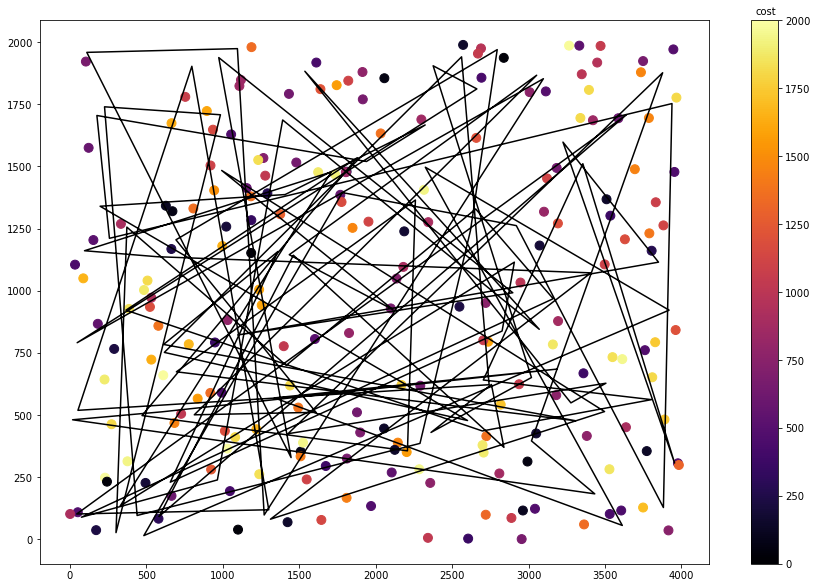

In [97]:
best_sol = history[totals.argmin()]

order = selected_data.index.to_list()
cycle = tsp_b.loc[order]
cycle = cycle.append(cycle.iloc[0])

plt.figure(figsize=(15, 10))
plt.scatter(tsp_a[0], tsp_a[1], 80, tsp_a[2], cmap='inferno')
plt.clim(0, 2000)
plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
plt.plot(cycle[0], cycle[1], c='black')
plt.show()

### Nearest neighbor

In [98]:
totals = []
dm = generate_dm(tsp_b, False)
for n in tqdm(range(200)):
    totals.append(nearest_neighbour(tsp_b, n, dm)[0]) 
totals = np.array(totals)
print("Best score: ", totals.min())
print("Worst score: ", totals.max())
print("Mean score: ", totals.mean())

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2149.89it/s]

Best score:  74413.0
Worst score:  93154.0
Mean score:  82446.675


12


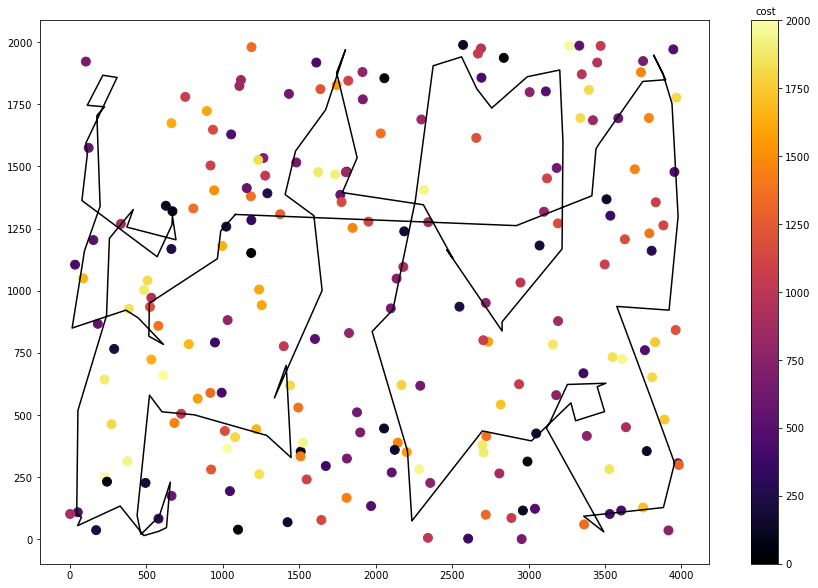

In [99]:
best_sol = totals.argmin()
print(best_sol)
cost, history = nearest_neighbour(tsp_a,best_sol, dm)

cycle = tsp_b.loc[history]
cycle = cycle.append(cycle.iloc[0])

plt.figure(figsize=(15, 10))
plt.scatter(tsp_a[0], tsp_a[1], 80, tsp_a[2], cmap='inferno')
plt.clim(0, 2000)
plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
plt.plot(cycle[0], cycle[1], c='black')
plt.show()

### Greedy cycle

In [104]:
totals = []
for i in tqdm(range(200)):
    totals.append(get_total_greedy_cycle_cost(tsp_b, dm, i)[0])
totals = np.array(totals)
print("Best score: ", totals.min())
print("Worst score: ", totals.max())
print("Mean score: ", totals.mean())

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:24<00:00,  1.02s/it]

Best score:  68655.0
Worst score:  76230.0
Mean score:  70656.38


50


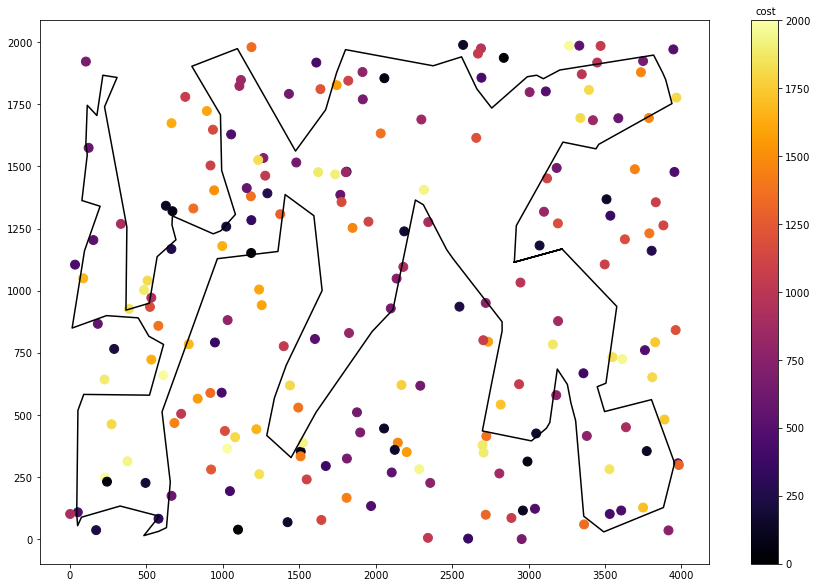

In [105]:
best_sol = totals.argmin()
print(best_sol)
cycle = get_total_greedy_cycle_cost(tsp_b, dm, best_sol)[1]
cycle = [x[0].split('_') for x in cycle ]
order = ['0']
while len(order) < 100:
    for n1, n2 in cycle:
        if n1 == order[-1]:
            order.append(n2)

order = [int(x) for x in order]
cycle = tsp_b.loc[order]
cycle = cycle.append(cycle.iloc[0])


plt.figure(figsize=(15, 10))
plt.scatter(tsp_a[0], tsp_a[1], 80, tsp_a[2], cmap='inferno')
plt.clim(0, 2000)
plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
plt.plot(cycle[0], cycle[1], c='black')
plt.show()